In [6]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pylab
from tqdm import trange
import scipy
import scipy.stats as stats
from scipy.stats import bernoulli

In [7]:
def is_consensus(x, fix):
    res = True
    count = 0
    for i in range(1, len(x)):
        if x[i-1] != x[i]:
            count += 1
    if count > 2:
        res = False
    return res
def clusters(x0,eps2, fix = {}):
    count = [x0[0]]
    l=0
    for i in range(1,len(x0)):
        if i not in fix:
            for j in range (len(count)):
                if np.abs(x0[i] - count[j])<eps2:
                    l+=1
            if l==0:
                count.append(x0[i])
            l=0
    return np.array(count)

In [8]:
def compare (x ,y, eps):
    result = 1
    for k in range(len(x)):
        if abs(x[k] - y[k]) >= eps:
            result = 0
    return bool(result)

def insert_agent(x, ind):
    if  ind != 0:
        opinion = (x[ind]+x[ind-1])/2
    else:
        opinion = x[ind]
    _X = np.insert(x,ind,opinion)
    return _X

def new_op(x, i, eps):
    count = 1
    summ = x[i]
    for k in range(len(x)):
        if (abs(x[i] - x[k]) < eps) and (i != k):
            #print(i, j, x[i], x[j])
            summ += x[k]
            count += 1
    #print(summ, count)
    return summ/count

def pair_count (x0, fix = {}):
    count = [0, 0]
    for i in range(len(x0)):
        if i not in fix:
            if x0[i] >= 0.5:
                count[0] += 1
            else:
                count[1] += 1
    #count[0] = count[0]/len(x0)
    #count[1] = count[1] / len(x0)
    return count

def Hen_Kr (x0, eps, eps2,fix, v):
    X = [np.array(x0)]
    t = 0
    while True:
        X.append(np.zeros(len(x0)))
        t += 1
        for j in range(len(x0)):
            if j not in fix:
                X[t][j] = new_op(X[t - 1], j, eps)
            else:
                if X[t - 1][j] + v <= 1:
                    X[t][j] = X[t - 1][j] + v
                else:
                    X[t][j] = 1
        if compare(X[t], X[t - 1], eps2):
            break
    return X, t

def find_fix(x0):
    diff = 1
    ind = 0
    for j in range (len(x0)):
        if (x0[j] - 0.5 < diff) and (x0[j] - 0.5 >= 0):
            ind = j
            diff = abs(0.5 - x0[j])
    return ind

In [9]:

def Hen_Kr_actm2_statistics (x0, eps, eps2,fix, v, prob):
    X = [np.array(x0)]
    t = 0
    consensus_value = 0
    consensus_time = 0
    consensus_flag = True
    pos0_6_time = 0
    pos0_6_flag = True
    while True:
        X.append(np.zeros(len(x0)))
        active_mask = bernoulli.rvs(p=prob, size=n)
        t += 1
        for j in range(len(x0)):
            if j not in fix and active_mask[j]==1:
                X_prev = np.copy(X[t -1])
                X_prev[active_mask==0]=0-2*eps - 2*eps2 
                X[t][j] = new_op(X_prev, j, eps)
                X[t][active_mask==0]=X[t-1][active_mask==0]
            else:
                if X[t - 1][j] + v <= 1:
                    X[t][j] = X[t - 1][j] + v
                else:
                    X[t][j] = 1
        if consensus_flag:
            ctrs = clusters(X[t],eps,fix_control)
            if len(ctrs) ==1:
                consensus_flag = False
                consensus_time = t
                consensus_value = X[t][0]
        if pos0_6_flag and np.all(X[t]>= 0.6):
            pos0_6_time = t
            pos0_6_flag = False
        if compare(X[t], X[t - 1], eps2):
            break
    return X, t, consensus_value, consensus_time, pos0_6_time

In [10]:
print('number of agents: ')
#n = int(input())
n = 50
print(n)
eps = 0.2
eps2 = 0.001

number of agents: 
50


In [11]:
x0 = np.random.sample(n)
x0.sort()

In [52]:
cons_value_data = np.asarray([])
cons_time_data = np.asarray([])
positive_time_data = np.asarray([])
stop_time_data = np.asarray([])
cluster_numbers = np.asarray([])
cluster_diff = np.array([])

count_experiments = 100
count_activ = 25
prob=0.5

fix_control = set({})
v_c = 0
count=0.

In [53]:
def clust_diff(cl_c,cl):
    if len(cl_c)==len(cl):
        diff = cl-cl_c
        #print(diff)
        return diff

In [54]:
for i in trange(count_experiments):
    
    x0 = np.random.sample(n)
    x0.sort()
    
    X_control, t_control = Hen_Kr(x0,eps,eps2,fix_control, v_c)
    cl_control = clusters(X_control[t_control],eps,fix_control)
    
    for j in range(count_activ):
        
        X, t, cons_value, cons_time, positive_time = Hen_Kr_actm2_statistics(x0, eps, eps2, fix_control,v_c, prob)
        cltrs = clusters(X[t],eps,fix_control)
    
        cons_value_data = np.append(cons_value_data, cons_value)
        cons_time_data = np.append(cons_time_data, cons_time)
        positive_time_data = np.append(positive_time_data, positive_time)
        stop_time_data = np.append(stop_time_data, t)
        cluster_numbers = np.append(cluster_numbers, len(cltrs))
        
        if(len(cl_control)==len(cltrs)):
            count+=1
            diff = clust_diff(cl_control, cltrs)
            cluster_diff = np.append(cluster_diff, diff)
cluster_diff = np.array(cluster_diff)   
print('Average consensus time:', np.mean(cons_time_data))
print('Average consensus value in consensus time:', np.mean(cons_value_data))
print('Average time when consensus reached 0.6:', np.mean(positive_time_data))
print('Average stop time:', np.mean(stop_time_data))
print('Average number of clusters:', np.mean(cluster_numbers))
print('Average difference:', np.mean(cluster_diff[0::2]), np.mean(cluster_diff[1::2]))

count_coin = 0.
count_all = 0.
for i in range(count_experiments):
    if cons_time_data[i]!=0:
        count_all +=1
        if cons_time_data[i] == positive_time_data[i]:
            count_coin += 1
print(count_coin, count_all)
print('Percentage of consensus formation with value above 0.6:', count_coin / count_experiments)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.24it/s]

Average consensus time: 0.9008
Average consensus value in consensus time: 0.025967542387946088
Average time when consensus reached 0.6: 0.042
Average stop time: 19.8552
Average number of clusters: 2.176
Average difference: -0.006509092713697926 -0.002658571069599772
0.0 12.0
Percentage of consensus formation with value above 0.6: 0.0


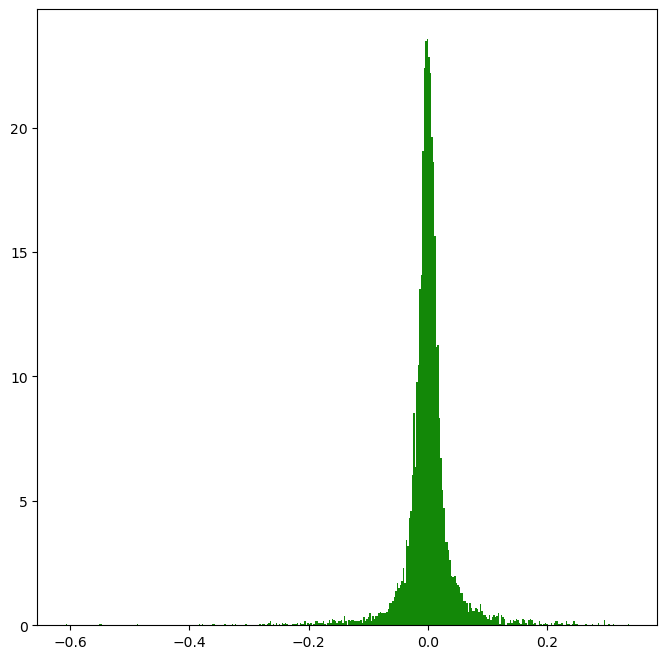

In [50]:
fig = plt.figure(facecolor='white', figsize=(8, 8))
hist = plt.hist(np.array(cluster_diff), density = True, bins='auto', stacked = True, color = '#138808')
#x = np.linspace(hist[1].min(), hist[1].max(), num=100)
#plt.plot(x, stats.expon.pdf(x,0, 0.025), color ="orange")
plt.show()

In [29]:
len(np.array(cluster_diff)), np.mean(cluster_diff), np.max(cluster_diff)

(14677, 0.0002674905064681701, 0.4342945141601635)

Кластеры совпали в 3668.0 случаев


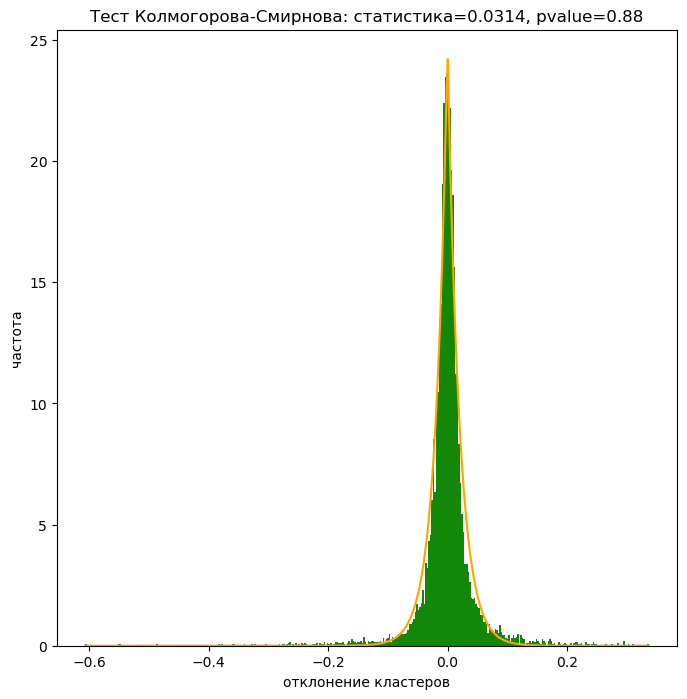

(KstestResult(statistic=0.02823179791976226, pvalue=0.005474337547151601),
 (7403,),
 23.580531853200647)

In [51]:
print(f'Кластеры совпали в {count} случаев')
fig = plt.figure(facecolor='white', figsize=(8, 8))
hist = plt.hist(np.array(cluster_diff), density = True, bins='auto', stacked = True, color = '#138808')
#x = np.linspace(hist[1].min(), hist[1].max(), num=100)
#plt.plot(x, stats.expon.pdf(x,0, 0.03), color ="orange")
x = np.linspace(hist[1].min(), hist[1].max(), num=500)
#x = np.linspace(-1., 1., num=500)
plt.plot(x, stats.laplace.pdf(x,0, 1/(2.1*hist[0].max())), color ="orange")
plt.xlabel('отклонение кластеров')
plt.ylabel('частота')
plt.title(f'Тест Колмогорова-Смирнова: статистика=0.0314, pvalue=0.88')
plt.show()
stats.ks_2samp(stats.laplace.rvs(0, 1/(2.1*hist[0].max()), size=len(np.array(cluster_diff))),np.array(cluster_diff), mode='auto'), cluster_diff.shape, hist[0].max()

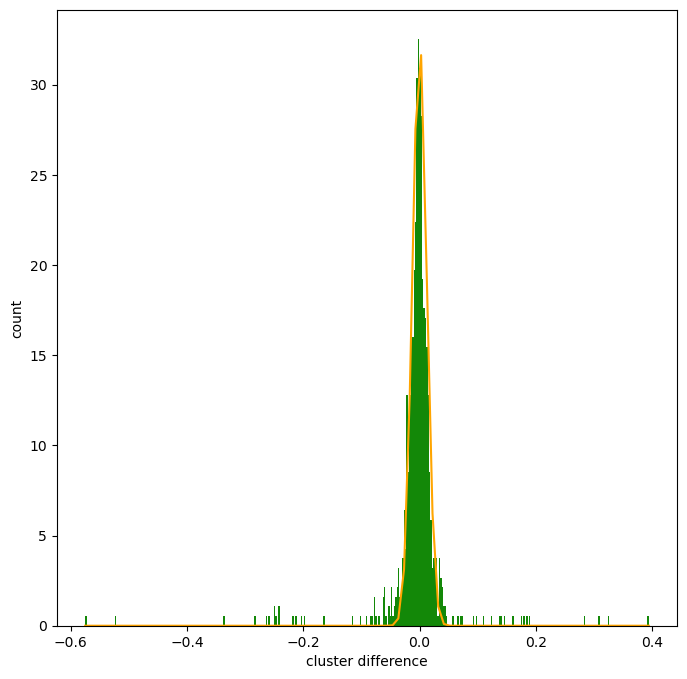

KstestResult(statistic=0.08656330749354005, pvalue=0.006035477722642276)

In [13]:
fig = plt.figure(facecolor='white', figsize=(8, 8))
hist = plt.hist(np.array(cluster_diff), density = True, bins=400, stacked = True, color = '#138808')
#x = np.linspace(hist[1].min(), hist[1].max(), num=100)
#plt.plot(x, stats.expon.pdf(x,0, 0.03), color ="orange")
x = np.linspace(hist[1].min(), hist[1].max(), num=100)
plt.plot(x, stats.norm.pdf(x,0, 1/(2.5*hist[0].max())), color ="orange")
plt.xlabel('cluster difference')
plt.ylabel('count')
plt.show()
stats.ks_2samp(stats.norm.rvs(0, 1/(2.5*hist[0].max()), size=len(np.array(cluster_diff))),np.array(cluster_diff), mode='auto')

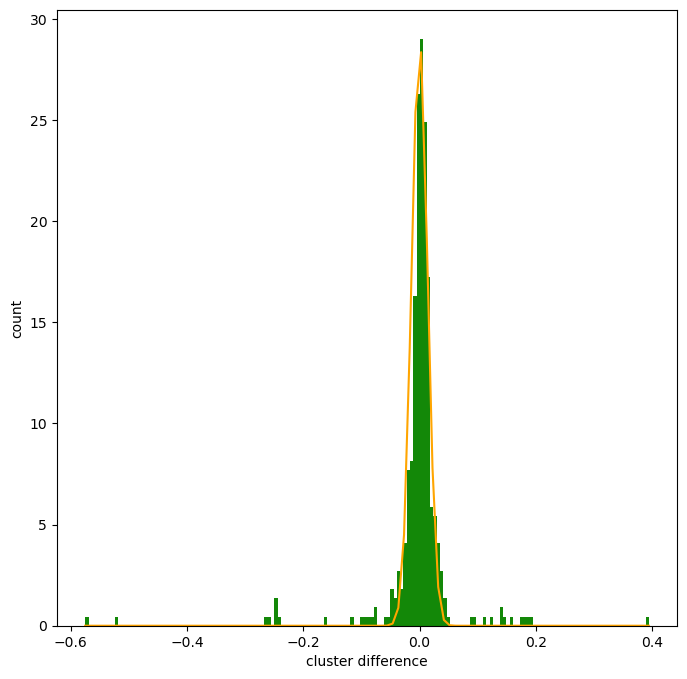

KstestResult(statistic=0.06976744186046512, pvalue=0.30327003721535334)

In [14]:
fig = plt.figure(facecolor='white', figsize=(8, 8))
hist = plt.hist(np.array(cluster_diff[1::2]), density = True, bins=170, stacked = True, color = '#138808')
#x = np.linspace(hist[1].min(), hist[1].max(), num=100)
#plt.plot(x, stats.expon.pdf(x,0, 0.03), color ="orange")
x = np.linspace(hist[1].min(), hist[1].max(), num=100)
plt.plot(x, stats.norm.pdf(x, 0, 1/(2.5*hist[0].max())), color ="orange")
plt.xlabel('cluster difference')
plt.ylabel('count')
plt.show()
stats.ks_2samp(stats.norm.rvs(0, 1/(2.5*hist[0].max()), size=len(np.array(cluster_diff[1::2]))),np.array(cluster_diff[1::2]), mode='auto')

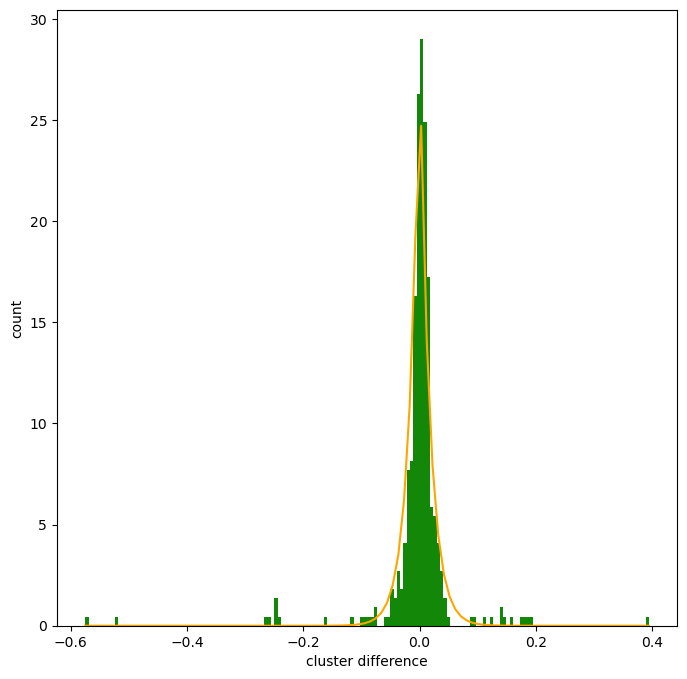

KstestResult(statistic=0.09819121447028428, pvalue=0.04428395656363704)

In [15]:
fig = plt.figure(facecolor='white', figsize=(8, 8))
hist = plt.hist(np.array(cluster_diff[1::2]), density = True, bins=170, stacked = True, color = '#138808')
#x = np.linspace(hist[1].min(), hist[1].max(), num=100)
#plt.plot(x, stats.expon.pdf(x,0, 0.03), color ="orange")
x = np.linspace(hist[1].min(), hist[1].max(), num=100)
plt.plot(x, stats.laplace.pdf(x,0,1/(2*max(hist[0]))), color ="orange")
plt.xlabel('cluster difference')
plt.ylabel('count')
plt.show()
stats.ks_2samp(stats.laplace.rvs(0,1/(2*max(hist[0])), size=len(np.array(cluster_diff[1::2]))),np.array(cluster_diff[1::2]), mode='asymp')

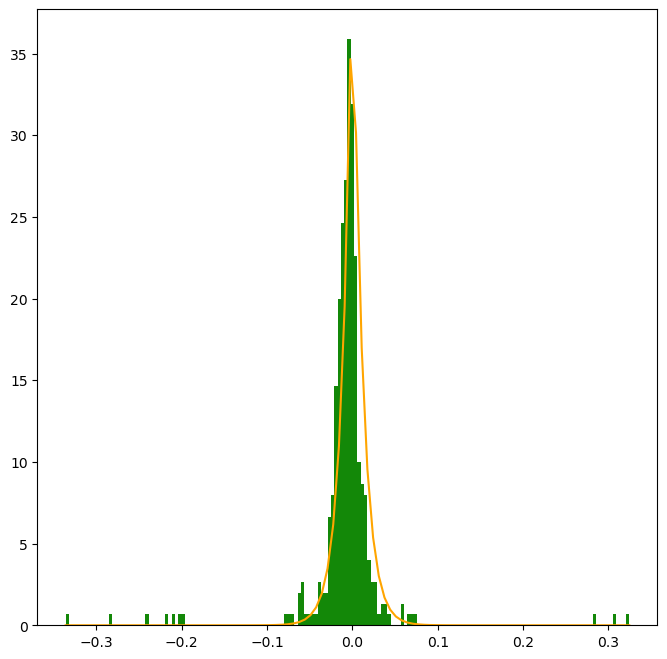

KstestResult(statistic=0.2532299741602067, pvalue=2.6270933218906566e-11)

In [16]:
fig = plt.figure(facecolor='white', figsize=(8, 8))
hist = plt.hist(np.array(cluster_diff[0::2]), density = True, bins=170, stacked = True, color = '#138808')
#x = np.linspace(hist[1].min(), hist[1].max(), num=100)
#plt.plot(x, stats.expon.pdf(x,0, 0.03), color ="orange")
x = np.linspace(hist[1].min(), hist[1].max(), num=100)
plt.plot(x, stats.laplace.pdf(x,0,1/(2.4*max(hist[0]))), color ="orange")
plt.show()
stats.ks_2samp(stats.laplace.rvs(0,1/(2*max(hist[0])), size=len(np.array(cluster_diff[0::2]))),np.array(cluster_diff[0::2]), mode='auto')

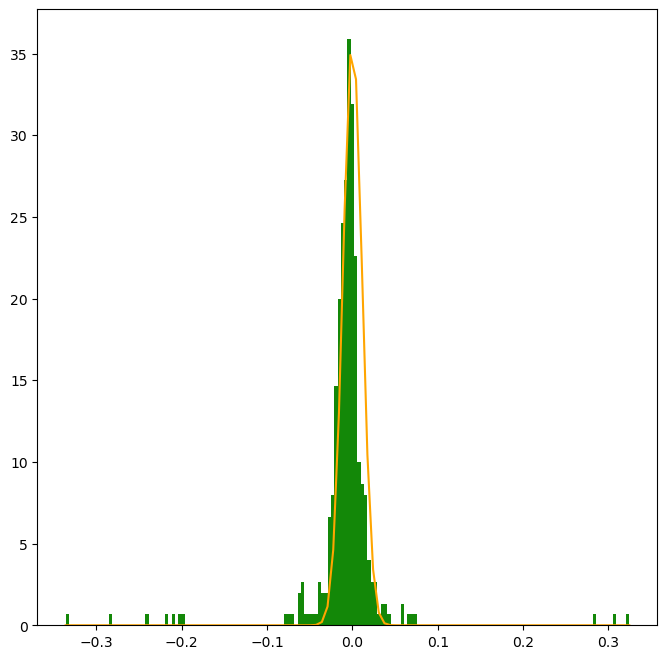

KstestResult(statistic=0.09043927648578812, pvalue=0.08437154242347647)

In [17]:
fig = plt.figure(facecolor='white', figsize=(8, 8))
hist = plt.hist(np.array(cluster_diff[0::2]), density = True, bins=170, stacked = True, color = '#138808')
#x = np.linspace(hist[1].min(), hist[1].max(), num=100)
#plt.plot(x, stats.expon.pdf(x,0, 0.03), color ="orange")
x = np.linspace(hist[1].min(), hist[1].max(), num=100)
plt.plot(x, stats.norm.pdf(x, 0, 1/(2.5*hist[0].max())), color ="orange")
plt.show()
stats.ks_2samp(stats.norm.rvs(np.mean(cluster_diff[0::2]), 1/(2.5*hist[0].max()), size=len(np.array(cluster_diff[0::2]))),np.array(cluster_diff[0::2]), mode='auto')

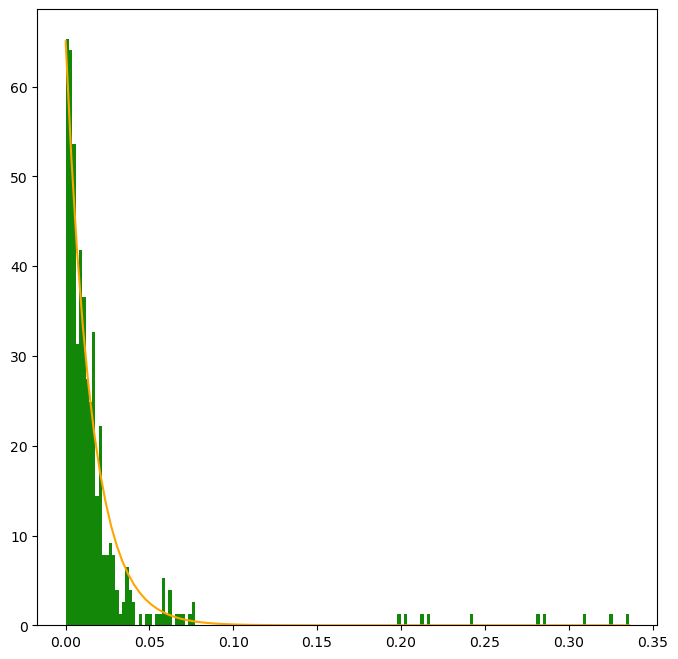

KstestResult(statistic=0.13178294573643412, pvalue=0.0023848456784812417)

In [18]:
fig = plt.figure(facecolor='white', figsize=(8, 8))
hist = plt.hist(np.array(np.abs(cluster_diff[0::2])), density = True, bins=170, stacked = True, color = '#138808')
x = np.linspace(hist[1].min(), hist[1].max(), num=100)
plt.plot(x, stats.expon.pdf(x,0, 1/max(hist[0])), color ="orange")
plt.show()
stats.ks_2samp(stats.expon.rvs(0, 1/max(hist[0]), size=len(np.array(cluster_diff[0::2]))),np.array(np.abs(cluster_diff[0::2])), mode='auto')

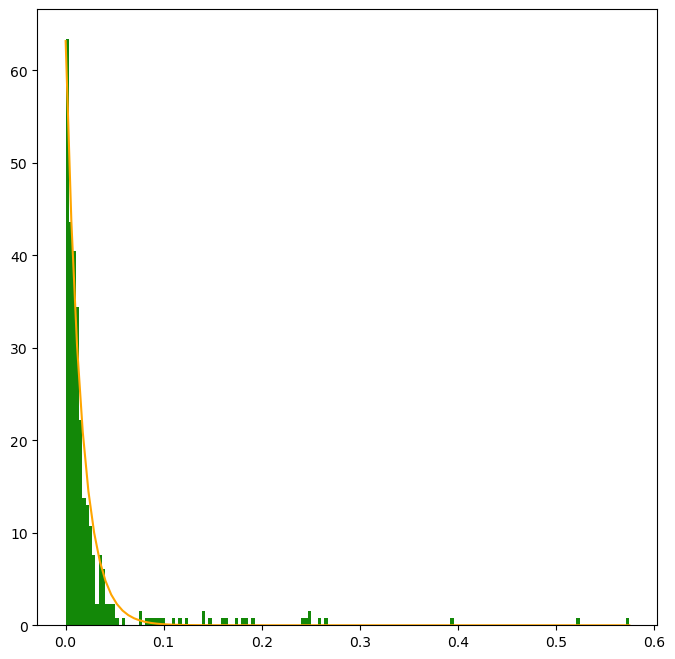

KstestResult(statistic=0.06976744186046512, pvalue=0.30327003721535334)

In [19]:
fig = plt.figure(facecolor='white', figsize=(8, 8))
hist = plt.hist(np.array(np.abs(cluster_diff[1::2])), density = True, bins=170, stacked = True, color = '#138808')
x = np.linspace(hist[1].min(), hist[1].max(), num=100)
plt.plot(x, stats.expon.pdf(x,0, 1/max(hist[0])), color ="orange")
plt.show()
stats.ks_2samp(stats.expon.rvs(0, 1/max(hist[0]), size=len(np.array(cluster_diff[1::2]))),np.array(np.abs(cluster_diff[1::2])), mode='auto')

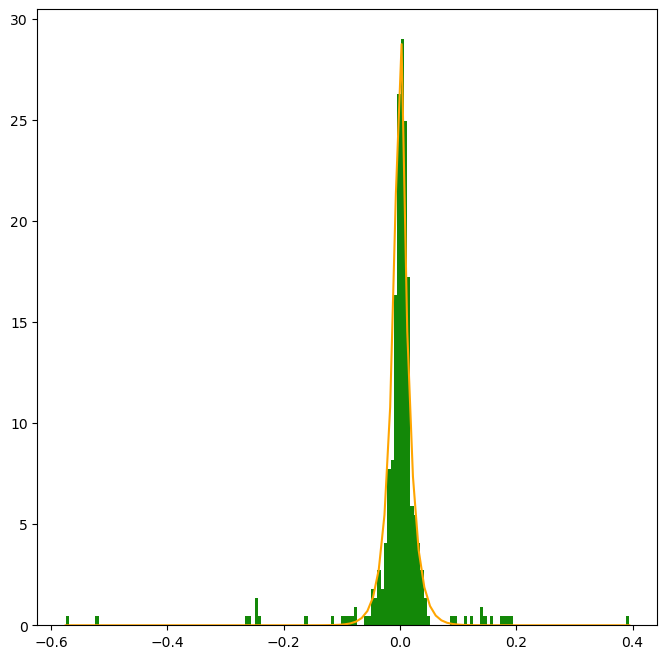

KstestResult(statistic=0.09043927648578812, pvalue=0.08437154242347647)

In [20]:
fig = plt.figure(facecolor='white', figsize=(8, 8))
hist = plt.hist(np.array(cluster_diff[1::2]), density = True, bins=170, stacked = True, color = '#138808')
#x = np.linspace(hist[1].min(), hist[1].max(), num=100)
#plt.plot(x, stats.expon.pdf(x,0, 0.03), color ="orange")
x = np.linspace(hist[1].min(), hist[1].max(), num=100)
plt.plot(x, stats.laplace.pdf(x,0,1/(2.4*max(hist[0]))), color ="orange")
plt.show()
stats.ks_2samp(stats.laplace.rvs(0,1/(2.4*max(hist[0])), size=len(np.array(cluster_diff[1::2]))),np.array(cluster_diff[1::2]), mode='auto')

x0 = np.linspace(0,1,50)
x0

X_control, t_control = Hen_Kr(x0,eps,eps2,fix_control, v_c)
finish_c = pair_count(X_control[t_control])
t_c_list = np.linspace(0, t_control, t_control + 1)

fig = plt.figure(facecolor='white', figsize=(9, 9))
cltrs = clusters(X[t],eps,fix_control)

ax2 = fig.add_subplot()
ax2.plot(t_c_list, X_control, linewidth=2)

ax2.title.set_text(f'p: {prob}, cl: {cltrs}')
plt.show()

prob=0.5
X, t, cons_value, cons_time, positive_time = Hen_Kr_actm2_statistics(x0, eps, eps2, fix_control,v_c, prob)
cltrs = clusters(X[t],eps,fix_control)
finish = pair_count(X[t])
t_list = np.linspace(0, t, t + 1)


fig = plt.figure(facecolor='white', figsize=(9, 9))

ax2 = fig.add_subplot()
ax2.plot(t_list, X, linewidth=2)

ax2.title.set_text(f'p: {prob}, cl: {cltrs}')
plt.show()

prob=0.5
X2, t2, cons_value, cons_time, positive_time = Hen_Kr_actm2_statistics(x0, eps, eps2, fix_control,v_c, prob)
cltrs = clusters(X[t],eps,fix_control)
finish = pair_count(X2[t])
t_list = np.linspace(0, t2, t2 + 1)

fig = plt.figure(facecolor='white', figsize=(9, 9))
cltrs = clusters(X2[t],eps,fix_control)
ax2 = fig.add_subplot()
ax2.plot(t_list, X2, linewidth=2)

ax2.title.set_text(f'p: {prob}, cl: {cltrs}')
plt.grid('true')
plt.show()

y0 = np.linspace(0,1,100)

Y_control, t_control = Hen_Kr(y0,eps,eps2,fix_control, v_c)
finish_c = pair_count(Y_control[t_control])
t_c_list = np.linspace(0, t_control, t_control + 1)

fig = plt.figure(facecolor='white', figsize=(9, 9))
cltrs = clusters(Y_control[t_control],eps,fix_control)

ax2 = fig.add_subplot()
ax2.plot(t_c_list, Y_control, linewidth=2)

ax2.title.set_text(f'p: {prob}, cl: {cltrs}')
plt.show()

prob=0.5
Y, t, cons_value, cons_time, positive_time = Hen_Kr_actm2_statistics(x0, eps, eps2, fix_control,v_c, prob)
cltrs = clusters(Y[t],eps,fix_control)
finish = pair_count(Y[t])
t_list = np.linspace(0, t, t + 1)

fig = plt.figure(facecolor='white', figsize=(9, 9))

ax2 = fig.add_subplot()
ax2.plot(t_list, Y, linewidth=2)

ax2.title.set_text(f'p: {prob}, cl: {cltrs}')
plt.grid('true')
plt.show()